# Breakout training with CNN

## Import Libraries

In [1]:
%matplotlib inline
import os
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

## Set Up Device

We import IPython's display module to aid us in plotting images to the screen later.

In [2]:
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

## Deep Q-Network

In [3]:
class DQN(nn.Module):
  
    def __init__(self, img_height, img_width, out_f):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)
        
        # Number of Linear input connections depends on output of conv2d layers
        # and therefore the input image size, so compute it.
        def conv2d_size_out(size, kernel_size = 5, stride = 2):
            return (size - (kernel_size - 1) - 1) // stride  + 1
        
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(img_height)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(img_width)))
        linear_input_size = convw * convh * 32
        self.head = nn.Linear(linear_input_size, out_f)      

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = x.to(device)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        return self.head(x.view(x.size(0), -1))

In [4]:
folder_save = "models"
os.makedirs(folder_save, exist_ok=True)

def exchange_weights(net1, net2):
    net1.load_state_dict(net2.state_dict())

def load_weights(net, filename):
    filename = os.path.join(folder_save, filename)
    net.load_state_dict(torch.load(filename))

def save_weights(net, filename: str):
    filename = os.path.join(folder_save, filename + ".pt")
    torch.save(net.state_dict(), filename)
    
def save_checkpoint(net, optimizer, num_episodes):
    checkpoint_dict = {
        "parameters": net.state_dict(),
        "optimizer": optimizer.state_dict(),
        "episode": num_episodes
    }
    filename = os.path.join(folder_save, "checkpoint.pt")
    torch.save(checkpoint_dict, filename)

## Experience class

In [5]:
Experience = namedtuple(
    'Experience',
    ('state', 'action', 'next_state', 'reward')
)

In [6]:
e = Experience(2,3,1,4)
e

Experience(state=2, action=3, next_state=1, reward=4)

## Replay Memory

In [7]:
class ReplayMemory():
  
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.push_count = 0       # Number of experiences added to the memory

    def push(self, experience):
        if len(self.memory) < self.capacity:
            self.memory.append(experience)
        else:
            self.memory[self.push_count % self.capacity] = experience  # overwrite the first experiences first
        self.push_count += 1

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def can_provide_sample(self, batch_size):
        return len(self.memory) >= batch_size    # can we sample from memory?

    def __len__(self):
        return len(self.memory)

## Epsilon Greedy Strategy

In [8]:
class EpsilonGreedyStrategy():

    def __init__(self, start, end, decay):
        self.start = start
        self.end = end
        self.decay = decay

    def get_exploration_rate(self, agent_current_step):
        return self.end + (self.start - self.end) * \
            math.exp(-1. * agent_current_step * self.decay)

## Reinforcement Learning Agent

In [9]:
class Agent():

    def __init__(self, strategy, num_actions, device):
        self.current_step = 0
        self.strategy = strategy
        self.num_actions = num_actions # number ofaction that can be taken from a given state
        self.device = device

    def select_action(self, state, policy_net):
        rate = self.strategy.get_exploration_rate(self.current_step)
        self.current_step += 1

        if rate > random.random():
            action = random.randrange(self.num_actions)
            return torch.tensor([action]).to(self.device) # explore      
        else:
            with torch.no_grad():  # since it's not training
                return policy_net(state).argmax(dim=1).to(self.device) # exploit

## Environment Manager

In [10]:
class EnvManager():

    def __init__(self, device):
        self.device = device
        self.env = gym.make('Breakout-v0').unwrapped
        #self.env = gym.make('BreakoutDeterministic-v4').unwrapped
        #self.env = gym.make('BreakoutNoFrameskip-v4').unwrapped
        self.env.reset() # to have an initial observation of the env
        self.current_screen = None
        self.done = False

    def reset(self):
        """ Resets the env to the initial state
        """
        self.env.reset()
        self.current_screen = None

    def close(self):
        """ Closes the env
        """
        self.env.close()

    def render(self, mode='human'):
        return self.env.render(mode)

    def num_actions_available(self):
        return self.env.action_space.n

    def take_action(self, action):        
        _, reward, self.done, _ = self.env.step(action.item())
        return torch.tensor([reward], device=self.device)

    def just_starting(self):
        return self.current_screen is None

    def get_state(self):
        """ Returns the current state of the env in the form of a procesed image of the screen
        """
        if self.just_starting() or self.done:
            self.current_screen = self.get_processed_screen()
            black_screen = torch.zeros_like(self.current_screen)
            return black_screen
        else:
            s1 = self.current_screen
            s2 = self.get_processed_screen()
            self.current_screen = s2
            return s2 - s1

    def get_screen_height(self):
        screen = self.get_processed_screen()
        return screen.shape[2]

    def get_screen_width(self):
        screen = self.get_processed_screen()
        return screen.shape[3]

    def get_processed_screen(self):
        screen = self.render(mode='rgb_array').transpose((2, 0, 1)) # PyTorch expects CHW
        screen = self.crop_screen(screen)
        return self.transform_screen_data(screen)

    def crop_screen(self, screen):
        screen_height = screen.shape[1]

        # Strip off top and bottom
        top = int(screen_height * 0.25)
        bottom = int(screen_height)
        screen = screen[:, top:bottom, :]
        return screen

    def transform_screen_data(self, screen):       
        # Convert to float, rescale, convert to tensor
        screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
        screen = torch.from_numpy(screen)

        # Use torchvision package to compose image transforms
        resize = T.Compose([
            T.ToPILImage()
            ,T.Resize((40,90))
            ,T.ToTensor()
        ])

        return resize(screen).unsqueeze(0).to(self.device) # add a batch dimension (BCHW)

### Example Screens

#### Non-Processed Screen

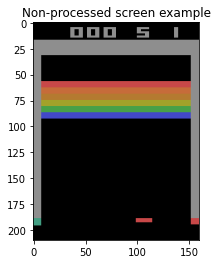

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
em = EnvManager(device)
em.reset()
screen = em.render('rgb_array')

plt.figure()
plt.imshow(screen)
plt.title('Non-processed screen example')
plt.show()

#### Processed Screen

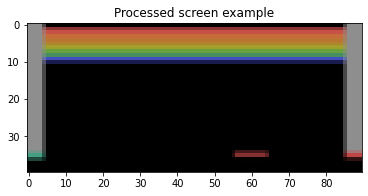

In [12]:
screen = em.get_processed_screen()

plt.figure()
plt.imshow(screen.squeeze(0).permute(1, 2, 0).cpu(), interpolation='none')
plt.title('Processed screen example')
plt.show()

#### Starting State

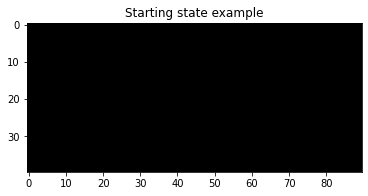

In [13]:
screen = em.get_state()

plt.figure()
plt.imshow(screen.squeeze(0).permute(1, 2, 0).cpu(), interpolation='none')
plt.title('Starting state example')
plt.show()

#### Non-Starting State

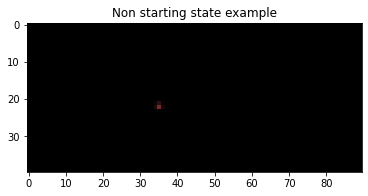

In [14]:
for i in range(5):
    em.take_action(torch.tensor([1]))
screen = em.get_state()

plt.figure()
plt.imshow(screen.squeeze(0).permute(1, 2, 0).cpu(), interpolation='none')
plt.title('Non starting state example')
plt.show()

#### Ending State

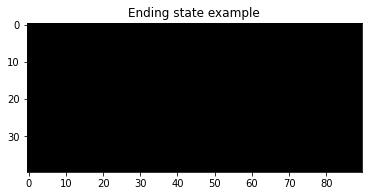

In [15]:
em.done = True
screen = em.get_state()

plt.figure()
plt.imshow(screen.squeeze(0).permute(1, 2, 0).cpu(), interpolation='none')
plt.title('Ending state example')
plt.show()
em.close()

## Utility Functions

### Plotting

In [16]:
def plot_durations(values, moving_avg_period):
    ax1 = plt.subplot(1, 2, 1)
    plt.clf()  # Clear the current figure.
    plt.xlabel('Episode', fontsize=14)
    plt.ylabel('Duration', fontsize=14)
    plt.plot(values)
    moving_avg = get_moving_average(moving_avg_period, values)
    plt.plot(moving_avg)    
    plt.pause(0.001)
    print("Episode", len(values), "\n", \
        moving_avg_period, "episode duration moving avg:", moving_avg[-1])
    #if is_ipython: display.clear_output(wait=True)

def plot_rewards(values, moving_avg_period):
    ax2 = plt.subplot(1, 2, 2)
    plt.clf()
    plt.xlabel('Episode', fontsize=14)
    plt.ylabel('Reward', fontsize=14)
    plt.plot(values)
    moving_avg = get_moving_average(moving_avg_period, values)
    plt.plot(moving_avg)    
    plt.pause(0.001)
    print("Episode", len(values), "\n", \
        moving_avg_period, "episode reward moving avg:", moving_avg[-1])
    if is_ipython: display.clear_output(wait=True)

def get_moving_average(period, values):
    values = torch.tensor(values, dtype=torch.float)
    if len(values) >= period:
        moving_avg = values.unfold(dimension=0, size=period, step=1) \
            .mean(dim=1).flatten(start_dim=0)
        moving_avg = torch.cat((torch.zeros(period-1), moving_avg))
    else:
        moving_avg = torch.zeros(len(values))
    return moving_avg.numpy()

### Tensor Processing

In [17]:
def extract_tensors(experiences):
    # Convert batch of Experiences to Experience of batches
    batch = Experience(*zip(*experiences))

    t1 = torch.cat(batch.state)
    t2 = torch.cat(batch.action)
    t3 = torch.cat(batch.reward)
    t4 = torch.cat(batch.next_state)

    return (t1,t2,t3,t4)

**Exapmple of `Experience(*zip(*experiences))` used above.**

See https://stackoverflow.com/a/19343/3343043 for further explanation.

In [18]:
e1 = Experience(1,1,1,1)
e2 = Experience(2,2,2,2)
e3 = Experience(3,3,3,3)

experiences = [e1,e2,e3]
experiences

[Experience(state=1, action=1, next_state=1, reward=1),
 Experience(state=2, action=2, next_state=2, reward=2),
 Experience(state=3, action=3, next_state=3, reward=3)]

In [19]:
batch = Experience(*zip(*experiences))
batch

Experience(state=(1, 2, 3), action=(1, 2, 3), next_state=(1, 2, 3), reward=(1, 2, 3))

## Q-Value Calculator

In [20]:
class QValues():

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    @staticmethod
    def get_current(policy_net, states, actions):
        return policy_net(states).gather(dim=1, index=actions.unsqueeze(-1))

    @staticmethod        
    def get_next(target_net, next_states):                
        final_state_locations = next_states.flatten(start_dim=1) \
            .max(dim=1)[0].eq(0).type(torch.bool)
        non_final_state_locations = (final_state_locations == False)
        non_final_states = next_states[non_final_state_locations]
        batch_size = next_states.shape[0]
        values = torch.zeros(batch_size).to(QValues.device)
        values[non_final_state_locations] = target_net(non_final_states).max(dim=1)[0].detach()
        return values

## Main Program

In [21]:
# Hyperparameters
batch_size = 256
gamma = 0.999
eps_start = 1
eps_end = 0.01
eps_decay = 0.001
target_update = 50
memory_size = 100000
lr = 0.001
num_episodes = 1000

In [22]:
# Essential Objects

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on {device}")

em = EnvManager(device)
strategy = EpsilonGreedyStrategy(eps_start, eps_end, eps_decay)
agent = Agent(strategy, em.num_actions_available(), device)
memory = ReplayMemory(memory_size)

policy_net = DQN(em.get_screen_height(), em.get_screen_width(), em.num_actions_available()).to(device)
target_net = DQN(em.get_screen_height(), em.get_screen_width(), em.num_actions_available()).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()  # since we only use this net for inference

optimizer = optim.Adam(params=policy_net.parameters(), lr=lr)

### Training Loop

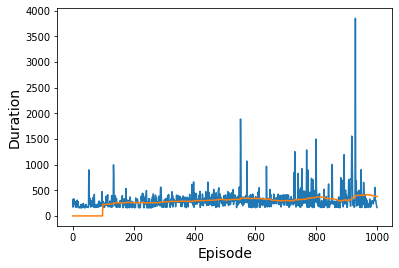

Episode 1000 
 100 episode duration moving avg: 377.16


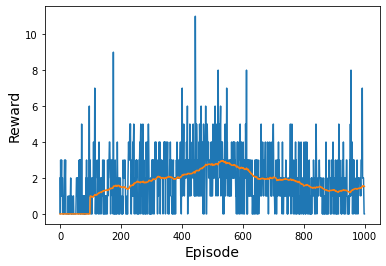

Episode 1000 
 100 episode reward moving avg: 1.53


In [23]:
episode_durations = []
episode_rewards = []

policy_net.train()

for episode in range(num_episodes):
    em.reset()
    state = em.get_state()
    episode_reward = 0

    for timestep in count():
        action = agent.select_action(state, policy_net)
        reward = em.take_action(action)
        episode_reward += reward
        next_state = em.get_state()
        memory.push(Experience(state, action, next_state, reward))
        state = next_state

        if memory.can_provide_sample(batch_size):
            experiences = memory.sample(batch_size)
            states, actions, rewards, next_states = extract_tensors(experiences)

            current_q_values = QValues.get_current(policy_net, states, actions)
            next_q_values = QValues.get_next(target_net, next_states)
            target_q_values = rewards + (gamma * next_q_values)  # Bellman's equation

            loss = F.mse_loss(current_q_values, target_q_values.unsqueeze(1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if em.done:
            episode_durations.append(timestep)
            plot_durations(episode_durations, 100)
            episode_rewards.append(episode_reward)
            plot_rewards(episode_rewards, 100)
            break

    if episode % target_update == 0:
        exchange_weights(target_net, policy_net)
        save_checkpoint(policy_net, optimizer, num_episodes)

save_weights(policy_net, "CNN_01")
em.close()

Let's play an episode to see if it learned to play:

In [29]:
#policy_net = DQN(em.get_screen_height(), em.get_screen_width(), em.num_actions_available()).to(device)
#load_weights(policy_net, "CNN_01.pt")
policy_net.eval()

for episode in range(1):
    em.reset()
    state = em.get_state()
    
    for timestep in count():
        em.render()
        action = agent.select_action(state, policy_net)
        reward = em.take_action(action)
        state = em.get_state()
        if em.done:
            break
        
em.close()

In [ ]:
# restore checkpoint
# filename = os.path.join(folder_save, "checkpoint.pt")
# checkpoint = torch.load(filename)
# policy_net = DQN(em.get_screen_height(), em.get_screen_width(), em.num_actions_available()).to(device)
# policy_net.load_state_dict(checkpoint["parameters"])
# optimizer.load_state_dict(checkpoint["optimizer"])
# episode_restart = checkpoint["episode"]
# for epoch in range(episode_restart, num_episodes):
#     # train loop

Let's observe the episode durations:

In [30]:
print(f"First 100 episodes average: {get_moving_average(100, episode_durations[:100])[99]}")
print(f"Last 100 episodes average: {get_moving_average(100, episode_durations[900:])[99]}")
print(f"Middle 100 episodes average: {get_moving_average(100, episode_durations[650:750])[99]}")

First 100 episodes average: 226.82000732421875
Last 100 episodes average: 377.1600036621094
Middle 100 episodes average: 316.67999267578125


In [32]:
print(np.max(episode_durations))
print(np.argmax(episode_durations))
print(episode_rewards[np.argmax(episode_durations)].item())

3855
928
1.0
